In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import plot_tree

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../availability.csv')
df['time_stamp'] = pd.to_datetime(df['last_update']).dt.round('30min')
df = df[df['id'] == 1]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1391 entries, 0 to 158413
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           1391 non-null   int64         
 1   time_stamp   1391 non-null   datetime64[ns]
 2   bikes        1391 non-null   int64         
 3   bike_stands  1391 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 54.3 KB


In [4]:
df.head()

,id,time_stamp,bikes,bike_stands
0,1,2024-02-01 00:00:00,0,31
114,1,2024-02-01 00:30:00,0,31
228,1,2024-02-01 01:00:00,0,31
342,1,2024-02-01 01:30:00,0,31
456,1,2024-02-01 02:00:00,0,31


In [5]:
X = df[['time_stamp']]
y = df[['bike_stands', 'bikes']]

X['last_update'] = pd.to_datetime(X['time_stamp'])
X['hour'] = X['time_stamp'].dt.hour
X['day_of_week'] = X['time_stamp'].dt.dayofweek
X['time_stamp'] = pd.to_datetime(X['time_stamp']).astype(int) // 10**9 

In [6]:
data = df.copy()
data['last_update'] = pd.to_datetime(data['last_update'])
data.set_index('time_stamp', inplace=True)

In [7]:
last_week_data = data.loc[data.index >= (data.index.max() - pd.Timedelta(days=7))]
hourly_data_last_week = last_week_data.resample('H').mean()

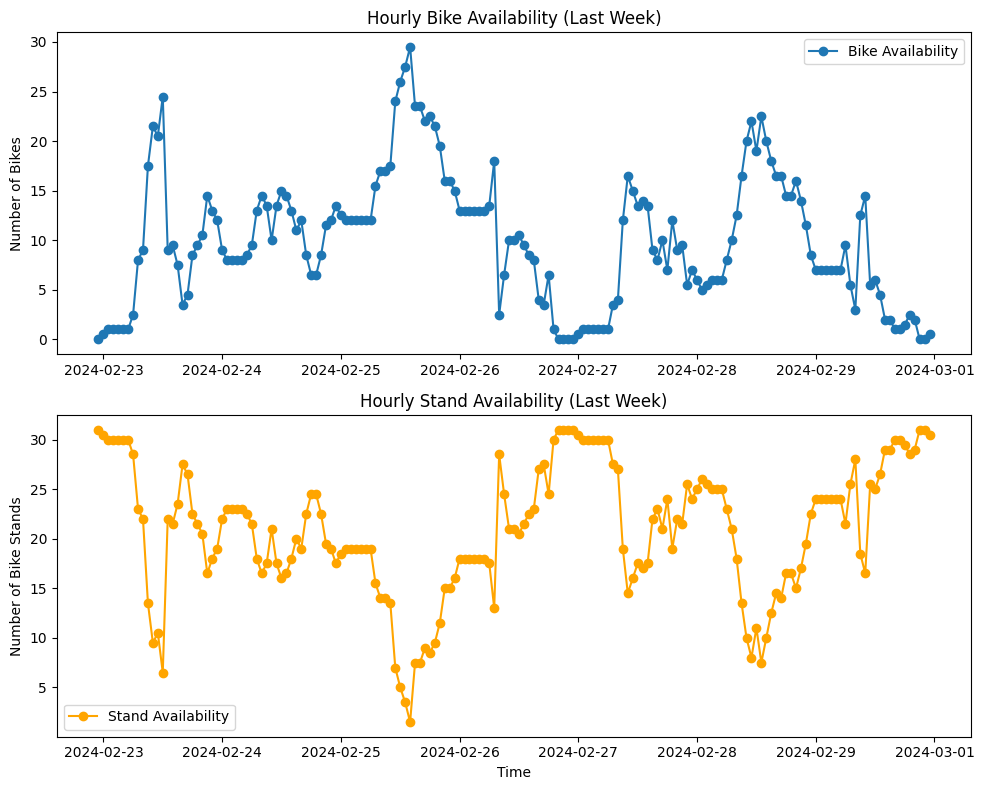

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axes[0].plot(hourly_data_last_week.index, hourly_data_last_week['bikes'], marker='o', label='Bike Availability')
axes[0].set_title('Hourly Bike Availability (Last Week)')
axes[0].set_ylabel('Number of Bikes')
axes[0].legend()

axes[1].plot(hourly_data_last_week.index, hourly_data_last_week['bike_stands'], marker='o', label='Stand Availability', color='orange')
axes[1].set_title('Hourly Stand Availability (Last Week)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Number of Bike Stands')
axes[1].legend()

plt.tight_layout()
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [10]:
def model_performance_trees(regrssor, output, algorithm):
    regrssor.fit(X_train, y_train[output])
    y_pred = regrssor.predict(X_test)
    print(algorithm, "\t", output)
    mae = mean_absolute_error(y_test[output], y_pred)
    print("MAE : ", mae)
    mse = mean_squared_error(y_test[output], y_pred)
    print("MSE : ", mse)
    r2 = r2_score(y_test[output], y_pred)
    print("R-squared : ", r2)

    plt.scatter(y_test[output], y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Validation Set Predictions vs. Actual Values')
    plt.show()
    

### Decision Trees

In [11]:
from sklearn.tree import DecisionTreeRegressor

Decision Tree 	 bikes
MAE :  1.4714285714285715
MSE :  7.128571428571429
R-squared :  0.9137777821660956


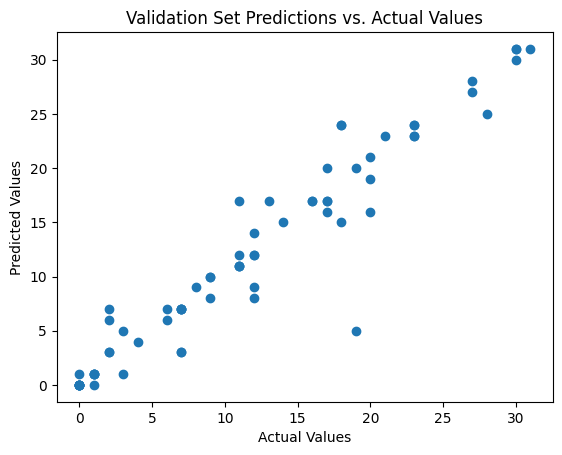

In [12]:
regressor_dt = DecisionTreeRegressor()
model_performance_trees(regressor_dt, 'bikes', 'Decision Tree')

Decision Tree 	 bike_stands
MAE :  1.4714285714285715
MSE :  7.014285714285714
R-squared :  0.9159007937673117


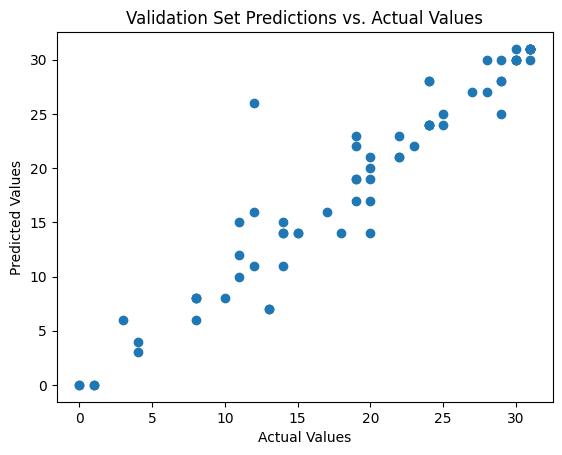

In [13]:
regressor_dt2 = DecisionTreeRegressor()
model_performance_trees(regressor_dt2, 'bike_stands', 'Decision Tree')

In [14]:
feature_importances = regressor_dt2.feature_importances_
print("Feature Importances:", feature_importances)

Feature Importances: [0.58824235 0.19221615 0.21954151]


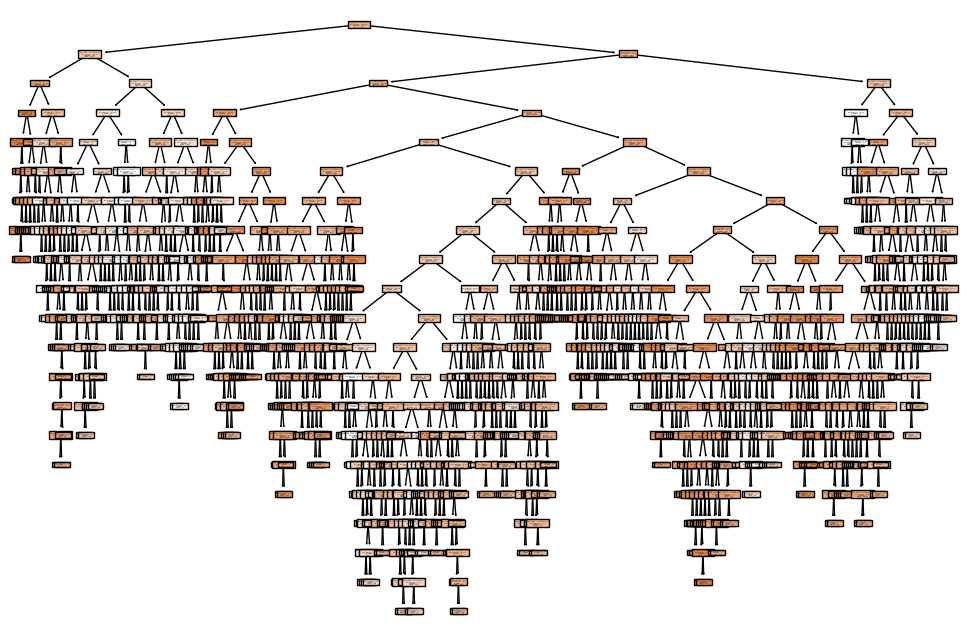

In [15]:
plt.figure(figsize=(12, 8))
plot_tree(regressor_dt2, filled=True, feature_names=X.columns)
plt.show()

### Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor

Random Forest 	 bikes
MAE :  1.3200000000000003
MSE :  4.913142857142859
R-squared :  0.9405740578007287


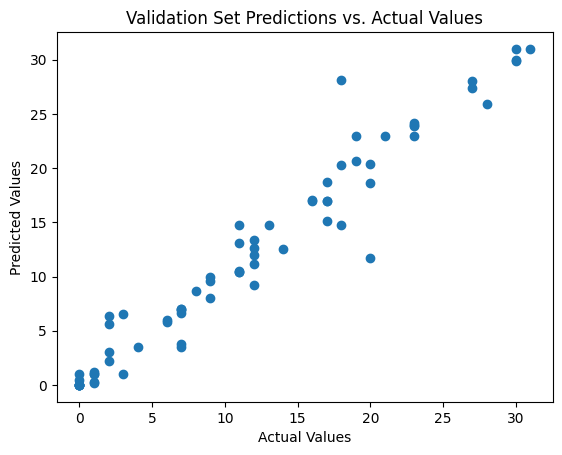

In [17]:
regressor_rf = RandomForestRegressor(n_estimators=10)
model_performance_trees(regressor_rf, 'bikes', 'Random Forest')

Random Forest 	 bike_stands
MAE :  1.2685714285714287
MSE :  3.9451428571428573
R-squared :  0.9526989067347877


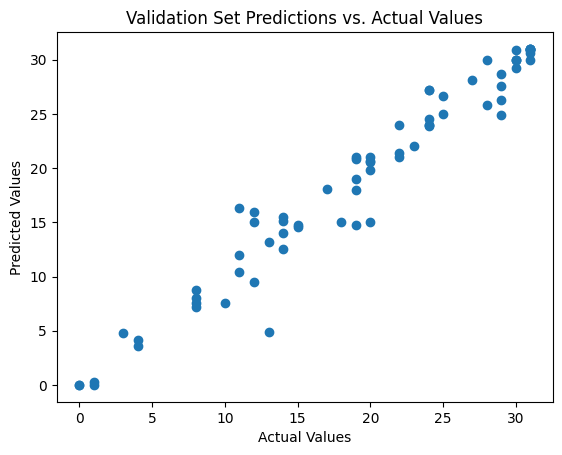

In [18]:
regressor_rf2 = RandomForestRegressor(n_estimators=10)
model_performance_trees(regressor_rf2, 'bike_stands', 'Random Forest')

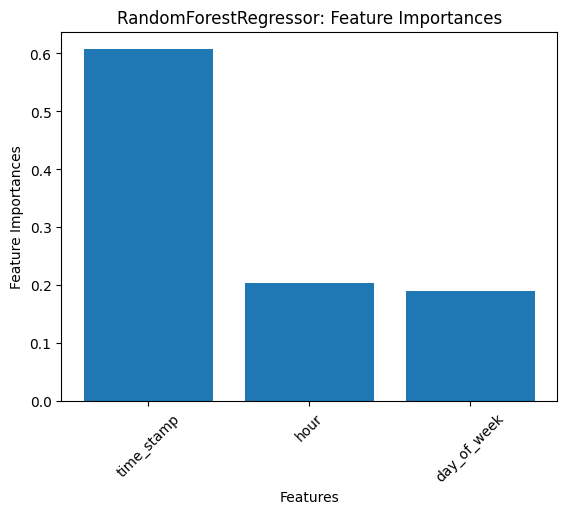

In [19]:
feature_importances_rf2 = regressor_rf2.feature_importances_
features = X_train.columns

plt.bar(features, feature_importances_rf2)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('RandomForestRegressor: Feature Importances')
plt.xticks(rotation=45)
plt.show()

### XGBoost

In [20]:
from xgboost import XGBRegressor

XG Boost 	 bikes
MAE :  1.2606855601099336
MSE :  3.378051143631602
R-squared :  0.959141454290142


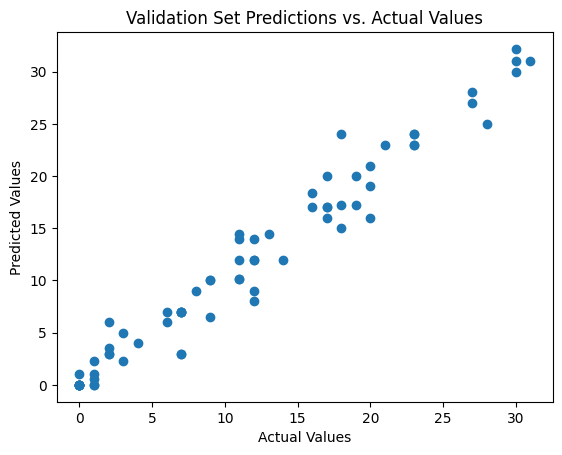

In [21]:
regressor_xgb = XGBRegressor(n_estimators=5000, learning_rate=0.9)
model_performance_trees(regressor_xgb, 'bikes', 'XG Boost')

XG Boost 	 bike_stands
MAE :  1.2482932857836464
MSE :  3.4943071539955293
R-squared :  0.9581042931590713


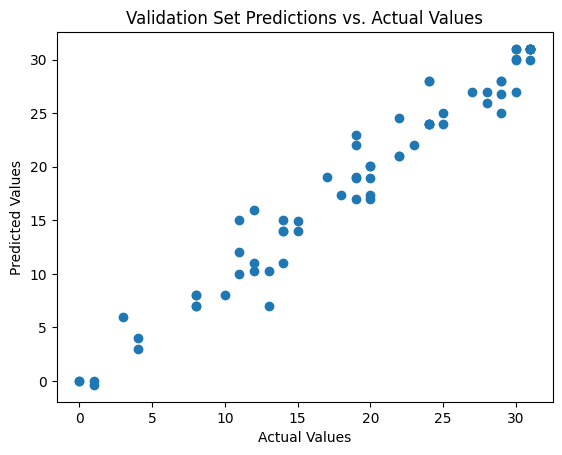

In [22]:
regressor_xgb2 = XGBRegressor(n_estimators=5000, learning_rate=0.9)
model_performance_trees(regressor_xgb2, 'bike_stands', 'XG Boost')

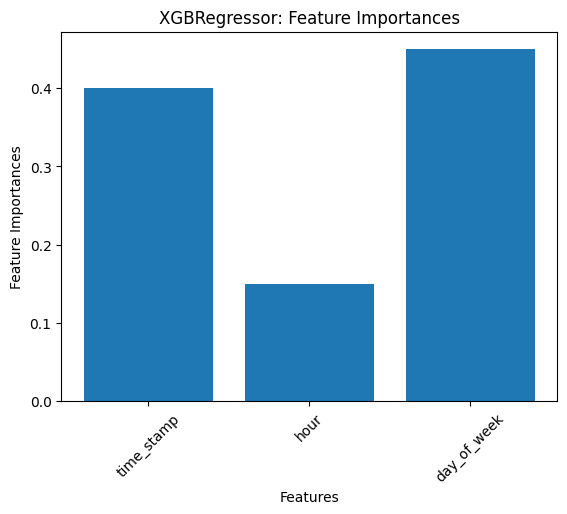

In [23]:
feature_importances_xgb2 = regressor_xgb2.feature_importances_
features = X_train.columns

plt.bar(features, feature_importances_xgb2)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('XGBRegressor: Feature Importances')
plt.xticks(rotation=45)
plt.show()

##

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['time_stamp', 'hour']),
        ('cat', OneHotEncoder(), ['day_of_week'])
    ])

In [25]:
X_processed = preprocessor.fit_transform(X)

In [26]:
scalar1 = StandardScaler()
y_processed1 = scalar1.fit_transform(y['bikes'].values.reshape(-1, 1))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed1, test_size=0.2, random_state=42)

In [28]:
def model_performance_non_bikes(regrssor, output, algorithm):
    regrssor.fit(X_train, y_train)
    y_pred = regrssor.predict(X_test)

    print(algorithm, "\t", output)
    mae = mean_absolute_error(y_test, y_pred)
    print("MAE : ", mae)
    mse = mean_squared_error(y_test, y_pred)
    print("MSE : ", mse)
    r2 = r2_score(y_test, y_pred)
    print("R-squared : ", r2)

    plt.scatter(scalar1.inverse_transform(y_test), scalar1.inverse_transform(y_pred))
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Validation Set Predictions vs. Actual Values')
    plt.show()

### KNN

In [29]:
from sklearn.neighbors import KNeighborsRegressor

KNN 	 bikes
MAE :  0.1177817709876005
MSE :  0.042163898622335945
R-squared :  0.9577191200208433


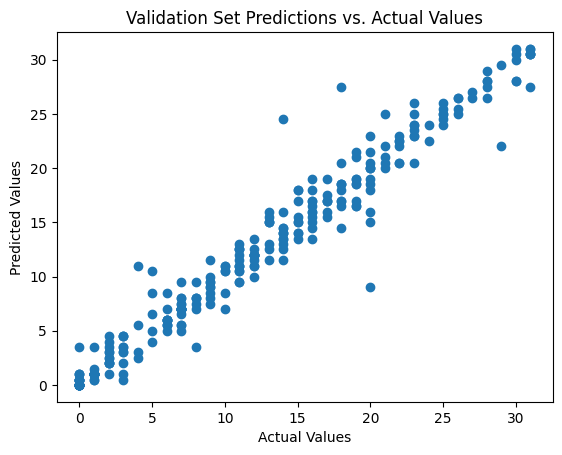

In [30]:
regressor_knn = KNeighborsRegressor(n_neighbors=2, n_jobs=-1)
model_performance_non_bikes(regressor_knn, 'bikes', 'KNN')

In [31]:
scalar2 = StandardScaler()
y_processed2 = scalar2.fit_transform(y['bike_stands'].values.reshape(-1, 1))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed2, test_size=0.2, random_state=42)

In [33]:
def model_performance_non_stand(regrssor, output, algorithm):
    regrssor.fit(X_train, y_train)
    y_pred = regrssor.predict(X_test)


    print(algorithm, "\t", output)
    mae = mean_absolute_error(y_test, y_pred)
    print("MAE : ", mae)
    mse = mean_squared_error(y_test, y_pred)
    print("MSE : ", mse)
    r2 = r2_score(y_test, y_pred)
    print("R-squared : ", r2)

    plt.scatter(scalar2.inverse_transform(y_test), scalar2.inverse_transform(y_pred))
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Validation Set Predictions vs. Actual Values')
    plt.show()

KNN 	 bike_stands
MAE :  0.11845825763161093
MSE :  0.04208570862058226
R-squared :  0.9576101605231693


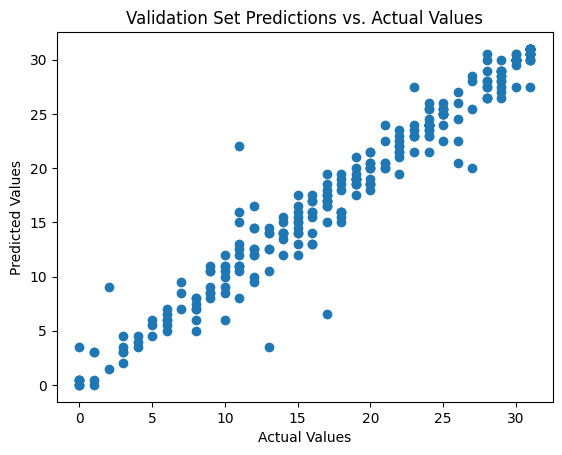

In [34]:
regressor_knn2 = KNeighborsRegressor(n_neighbors=2, n_jobs=-1)
model_performance_non_stand(regressor_knn2, 'bike_stands', 'KNN')

#

In [35]:
from datetime import datetime
import requests
import json

link = 'https://api.jcdecaux.com/vls/v1/stations'
api = '681b757e032447abea03a11443b614d0ba3cf5ef'
contract = 'Dublin'

response = requests.get(link, 
                        params={"apiKey": api, 
                                "contract": contract})
response.raise_for_status()
now = datetime.now()
data = response.text
data = json.loads(data)
data = pd.json_normalize(data)

In [36]:
data[data['number'] == 4]

,number,contract_name,name,address,banking,bonus,bike_stands,available_bike_stands,available_bikes,status,last_update,position.lat,position.lng
44,4,dublin,GREEK STREET,Greek Street,False,False,20,14,6,OPEN,1710179237000,53.346874,-6.272976


In [37]:
from tabulate import tabulate
filtered_data = data[data['number'] == 1]
filtered_data['time_stamp'] = pd.to_datetime(filtered_data['last_update'], unit='ms')
new_data = pd.DataFrame()
new_data['time_stamp'] = filtered_data['time_stamp']
new_data['hour'] = new_data['time_stamp'].dt.hour
new_data['day_of_week'] = new_data['time_stamp'].dt.dayofweek
new_data['time_stamp'] = new_data['time_stamp'].astype(int) // 10**9
new_data_processed = preprocessor.transform(new_data)

actual_bikes = filtered_data['available_bikes'].values[0]
predictions_bikes = [
    actual_bikes,
    regressor_rf.predict(new_data),
    regressor_dt.predict(new_data),
    regressor_xgb.predict(new_data),
    scalar1.inverse_transform(regressor_knn.predict(new_data_processed).reshape(-1, 1)).item()
]

actual_stands = filtered_data['available_bike_stands'].values[0]
predictions_stands = [
    actual_stands,
    regressor_rf2.predict(new_data),
    regressor_dt2.predict(new_data),
    regressor_xgb2.predict(new_data),
    scalar2.inverse_transform(regressor_knn2.predict(new_data_processed).reshape(-1, 1)).item()
]

headers = ["Model", "Predicted Value"]

model_names_bikes = ["Actual", "RF", "DT", "XGB", "KNN"]
data_bikes = list(zip(model_names_bikes, predictions_bikes))

model_names_stands = ["Actual", "RF2", "DT2", "XGB2", "KNN2"]
data_stands = list(zip(model_names_stands, predictions_stands))

print(f"Predicted Bikes Availability:")
print(tabulate(data_bikes, headers=headers))
print(f"\nPredicted Bikes Stands Availability:")
print(tabulate(data_stands, headers=headers))

Predicted Bikes Availability:
Model      Predicted Value
-------  -----------------
Actual             3
RF                 2.2
DT                10
XGB                2.01034
KNN                5

Predicted Bikes Stands Availability:
Model      Predicted Value
-------  -----------------
Actual             28
RF2                27.1
DT2                19
XGB2               28.5964
KNN2               26


In [38]:
from datetime import datetime, timedelta
current_date = datetime.now()
one_week_datetime_array = [(current_date + timedelta(hours=i)).strftime('%Y-%m-%d %H:%M:%S') for i in range(24 * 7)]
datetime_index = pd.to_datetime(one_week_datetime_array)

print(datetime_index)

DatetimeIndex(['2024-03-11 17:57:35', '2024-03-11 18:57:35',
               '2024-03-11 19:57:35', '2024-03-11 20:57:35',
               '2024-03-11 21:57:35', '2024-03-11 22:57:35',
               '2024-03-11 23:57:35', '2024-03-12 00:57:35',
               '2024-03-12 01:57:35', '2024-03-12 02:57:35',
               ...
               '2024-03-18 07:57:35', '2024-03-18 08:57:35',
               '2024-03-18 09:57:35', '2024-03-18 10:57:35',
               '2024-03-18 11:57:35', '2024-03-18 12:57:35',
               '2024-03-18 13:57:35', '2024-03-18 14:57:35',
               '2024-03-18 15:57:35', '2024-03-18 16:57:35'],
              dtype='datetime64[ns]', length=168, freq=None)


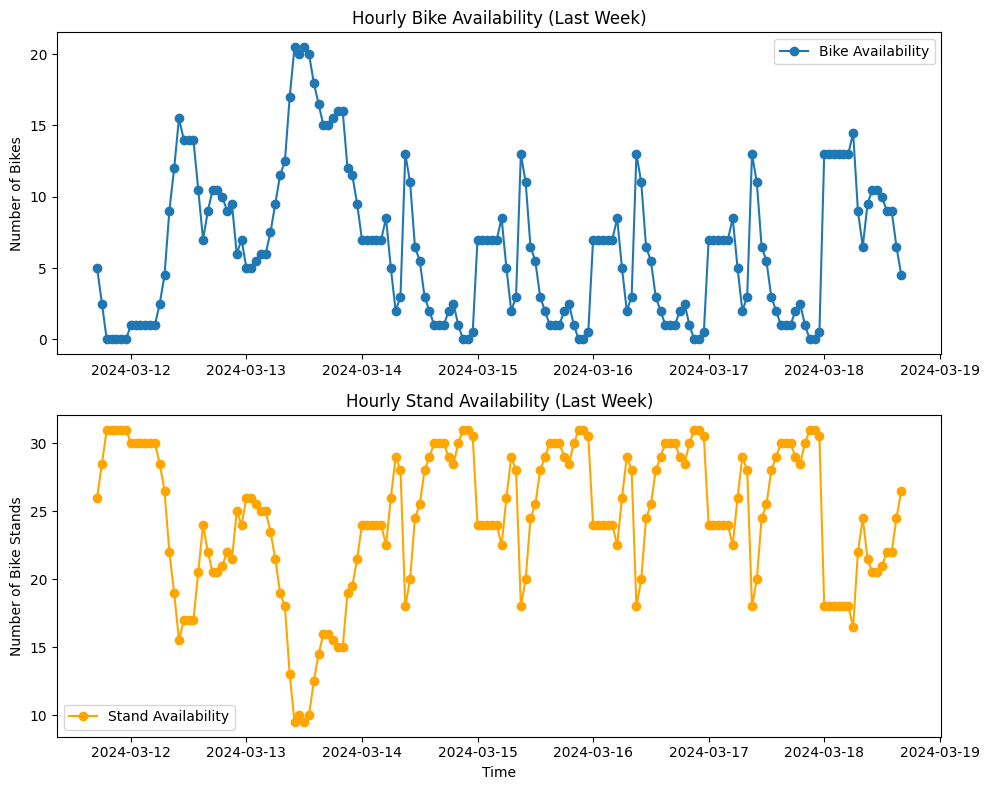

In [39]:
stands_res = []
bikes_res = []
for i in range(len(datetime_index)):
    filtered_data['time_stamp'] = datetime_index[i]
    new_data = pd.DataFrame()
    new_data['time_stamp'] = filtered_data['time_stamp']
    new_data['hour'] = new_data['time_stamp'].dt.hour
    new_data['day_of_week'] = new_data['time_stamp'].dt.dayofweek
    new_data['time_stamp'] = new_data['time_stamp'].astype(int) // 10**9
    new_data_processed = preprocessor.transform(new_data)
    bikes_res.append(scalar1.inverse_transform(regressor_knn.predict(new_data_processed).reshape(-1, 1)).item())
    stands_res.append(scalar2.inverse_transform(regressor_knn2.predict(new_data_processed).reshape(-1, 1)).item())

data = pd.DataFrame()
data["time_stamp"] = datetime_index
data["bikes"] = bikes_res
data["stands"] = stands_res

data['time_stamp'] = pd.to_datetime(data['time_stamp'])
data.set_index('time_stamp', inplace=True)

last_week_data = data.loc[data.index >= (data.index.max() - pd.Timedelta(days=7))]
hourly_data_last_week = last_week_data.resample('H').mean()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axes[0].plot(hourly_data_last_week.index, hourly_data_last_week['bikes'], marker='o', label='Bike Availability')
axes[0].set_title('Hourly Bike Availability (Last Week)')
axes[0].set_ylabel('Number of Bikes')
axes[0].legend()

axes[1].plot(hourly_data_last_week.index, hourly_data_last_week['stands'], marker='o', label='Stand Availability', color='orange')
axes[1].set_title('Hourly Stand Availability (Last Week)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Number of Bike Stands')
axes[1].legend()

plt.tight_layout()
plt.show()

KNN's predictions were more precise so will go ahead with knn

In [40]:
import pickle

df = pd.read_csv('../availability.csv')
df = df[df['id'] == 1]

X = df[['time_stamp']]
y = df[['bike_stands', 'bikes']]

X['time_stamp'] = pd.to_datetime(X['time_stamp']).dt.round('30min')
X['hour'] = X['time_stamp'].dt.hour
X['day_of_week'] = X['time_stamp'].dt.dayofweek
X['time_stamp'] = pd.to_datetime(X['time_stamp']).astype(int) // 10**9

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['time_stamp', 'hour']),
        ('cat', OneHotEncoder(), ['day_of_week'])
    ])

X_processed = preprocessor.fit_transform(X)

scalar1 = StandardScaler()
y_processed = scalar1.fit_transform(y['bikes'].values.reshape(-1, 1))

regressor_bike = KNeighborsRegressor(n_neighbors=2, n_jobs=-1)
regressor_bike.fit(X_processed, y_processed)

In [156]:
import requests
import json
import pandas as pd
import numpy as np
JCDecaux_dict = {
    'NAME' : "Dublin",
    'STATIONS' : "https://api.jcdecaux.com/vls/v1/stations",
    'API_KEY' : '681b757e032447abea03a11443b614d0ba3cf5ef'
}


response = requests.get(JCDecaux_dict['STATIONS'], 
                        params={"apiKey": JCDecaux_dict['API_KEY'], 
                                "contract": JCDecaux_dict['NAME']})
response.raise_for_status()
data = response.text
data = json.loads(data)
data = pd.json_normalize(data)

In [ ]:
id = 114

In [208]:
import pickle
from tabulate import tabulate

with open(f'ava_time/bikes/{id}.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)
regressor = loaded_model['regressor']
scaler = loaded_model['scaler']
preprocessor = loaded_model['preprocessor']

import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
df = data[data['number'] == id]

y = df[['available_bike_stands', 'available_bikes']]
temp = {
        'time_stamp' : [datetime.utcfromtimestamp(df[['last_update']].values[0][0] / 1000).strftime('%d-%m-%Y %H:%M:%S')]
    }

X = pd.DataFrame(temp)
X['time_stamp'] = pd.to_datetime(X['time_stamp']).dt.round('30min')
X['hour'] = X['time_stamp'].dt.hour
X['day_of_week'] = X['time_stamp'].dt.dayofweek
X['time_stamp'] = pd.to_datetime(X['time_stamp']).astype(int) // 10**9

pred1 = scaler.inverse_transform(regressor.predict(preprocessor.transform(X)).reshape(-1, 1))

with open(f'ava_time/stands/{id}.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)
regressor = loaded_model['regressor']
scaler = loaded_model['scaler']
preprocessor = loaded_model['preprocessor']

import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
df = data[data['number'] == id]

y = df[['available_bike_stands', 'available_bikes']]
temp = {
        'time_stamp' : [datetime.utcfromtimestamp(df[['last_update']].values[0][0] / 1000).strftime('%d-%m-%Y %H:%M:%S')]
    }

X = pd.DataFrame(temp)
X['time_stamp'] = pd.to_datetime(X['time_stamp']).dt.round('30min')
X['hour'] = X['time_stamp'].dt.hour
X['day_of_week'] = X['time_stamp'].dt.dayofweek
X['time_stamp'] = pd.to_datetime(X['time_stamp']).astype(int) // 10**9

pred2 = scaler.inverse_transform(regressor.predict(preprocessor.transform(X)).reshape(-1, 1))


table_data = [
    ("Bikes", df[['available_bikes']].values[0][0], int(np.round(pred1[0][0]))),
    ("Stands", df[['available_bike_stands']].values[0][0], int(np.round(pred2[0][0]))),
]

headers = ["Metric", "Actual Value", "Predicted Value"]
table = tabulate(table_data, headers=headers, tablefmt="grid")

print(table)

+----------+----------------+-------------------+
| Metric   |   Actual Value |   Predicted Value |
+==========+================+===================+
| Bikes    |              0 |                 1 |
+----------+----------------+-------------------+
| Stands   |             40 |                39 |
+----------+----------------+-------------------+
